### Sentiment Analysis of US Airlines Tweets

1. Exploratory data analysis
2. Textblob
3. WordCloud
4. Text classification modeling

In [5]:
import nltk
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import string
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk import pos_tag

from textblob import TextBlob

from wordcloud import WordCloud,STOPWORDS
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

#### Data Description

The dataset contains 14,640 tweets on US Airline posted in February 2015. These tweets are already classified as positive, negative and neutral. Furthermore, the negative tweets are also classified on the basis of the negative reasons.

In [7]:
data = pd.read_csv('/Users/shalinisingh/Desktop/Projects/USAirlines_twitter/Tweets.csv')
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [8]:
data.shape

(14640, 15)

#### Variable Description

1. tweet_id: Tweet ID
2. airline_sentiment: Sentiment of each Tweet (Positive, Neutral, Negative)
3. airline_sentiment_confidence: Information not given
4. negativereason: The reason of each negative comment
5. negativereason_confidence: Information not given
6. airline: The name of the airline company
7. airline_sentiment_gold: Information not given
8. name: The username of each Twitter account
9. negativereason_gold: Information not given
10. retweet_count: The number of re-posting of each Tweet
11. text: The content of each Tweet
12. tweet_coord: Information not given
13. tweet_created: The exact time each tweet was posted
14. tweet_location: Information not given
15. user_timezone: The time zone that each user was in

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


- Total number of tweets per Airline

In [10]:
data.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False)

airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline_sentiment, dtype: int64

In [11]:
#The percentage of tweets that each airline accounts in this dataset
(data[['airline', 'text']].groupby('airline').count()/len(data)).sort_values(by='text', ascending=False)

,text
airline,
United,0.261066
US Airways,0.198975
American,0.188456
Southwest,0.165301
Delta,0.151776
Virgin America,0.034426


Text(0.5, 1.0, 'Tweets Frequency by Airline')

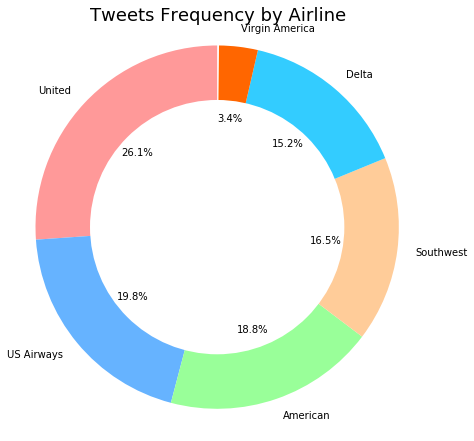

In [12]:
#Representing in Pie chart.
labels = ['United','US Airways','American','Southwest','Delta','Virgin America']
sizes = [0.261, 0.198, 0.188, 0.165, 0.152, 0.0344]
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#33ccff', '#ff6600']
fig1, ax1 = plt.subplots(figsize=(6.5, 6))
ax1.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90)

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  
plt.tight_layout()
plt.title('Tweets Frequency by Airline', fontsize=18)

Text(0, 0.5, 'Mood')

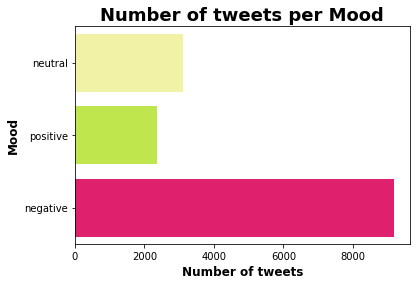

In [13]:
sns.countplot(y='airline_sentiment', data=data, palette=['#ffff99','#ccff33','#ff0066'])
plt.title('Number of tweets per Mood', fontsize=18, fontweight = 'bold')
plt.xlabel('Number of tweets', fontsize = 12, fontweight = 'bold')
plt.ylabel('Mood', fontsize = 12, fontweight = 'bold')

In [14]:
#How customers feel about each airline
pd.crosstab(data.airline, data.airline_sentiment)

airline_sentiment,negative,neutral,positive
airline,,,
American,1960,463,336
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


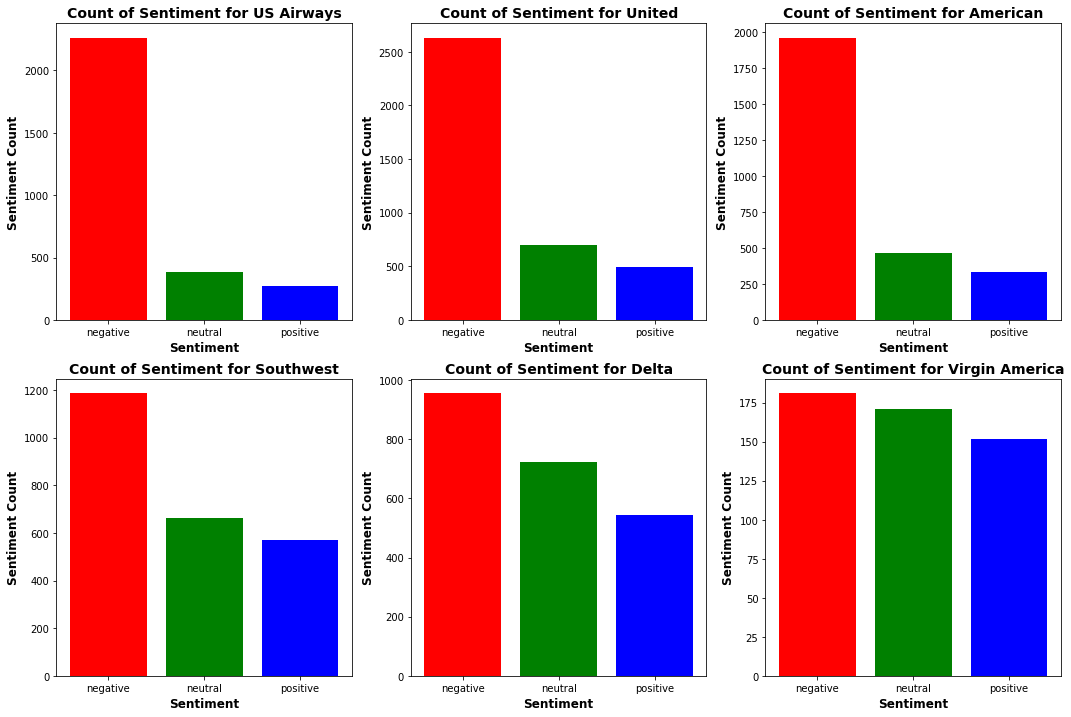

In [15]:
airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']
plt.figure(1,figsize=(18, 12))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    new_df=data[data['airline']==i]
    count=new_df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count, color=['red', 'green', 'blue'])
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Sentiment Count', fontweight = 'bold', fontsize = 12)
    plt.xlabel('Sentiment', fontweight = 'bold', fontsize = 12)
    plt.title('Count of Sentiment for '+i, fontweight = 'bold', fontsize = 14)

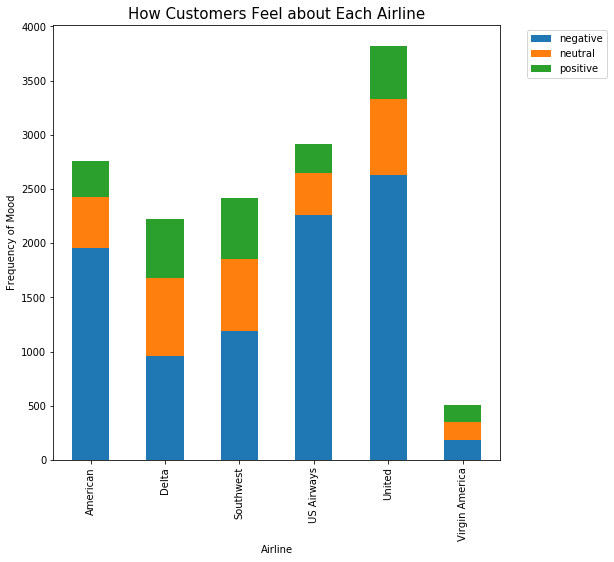

In [16]:
#Visualize sentiment per airline
_ = pd.crosstab(data.airline, data.airline_sentiment).plot(kind="bar",title='How Customers Feel about Each Airline',figsize=(8,8),stacked=True)
_.title.set_size(15)
_.set_xlabel('Airline')
_.set_ylabel('Frequency of Mood')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

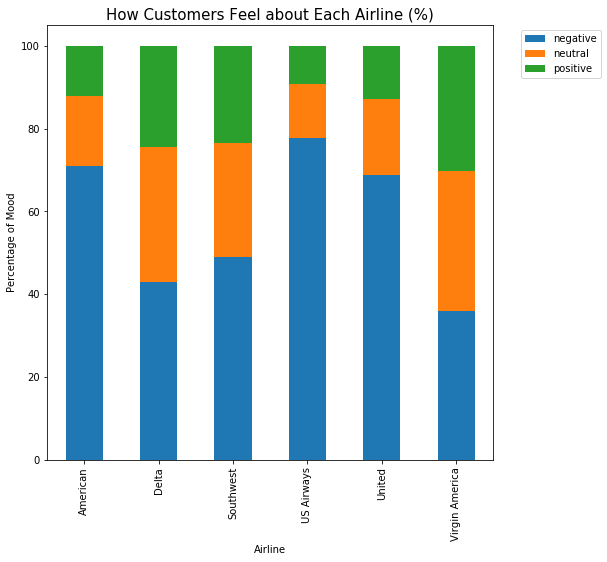

In [17]:
#Visualize sentiment after normalization
_ = pd.crosstab(data.airline, data.airline_sentiment).apply(lambda x: x / x.sum() * 100, axis=1).plot(kind='bar',title='How Customers Feel about Each Airline (%)',figsize=(8,8),stacked=True)
_.title.set_size(15)
_.set_xlabel('Airline')
_.set_ylabel('Percentage of Mood')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

US Airlines got the highest negative tweets

Text(0, 0.5, 'Negative Reasons')

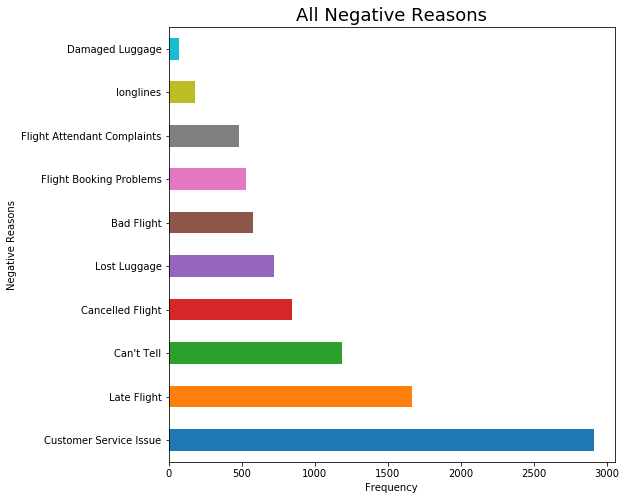

In [18]:
#Visualize the reasons for negative tweets
data.negativereason.value_counts().plot(kind='barh',figsize=(8,8))
plt.title('All Negative Reasons', fontsize=18)
plt.xlabel('Frequency')
plt.ylabel('Negative Reasons')

Customer Service seems to be the major reason for the negative tweets

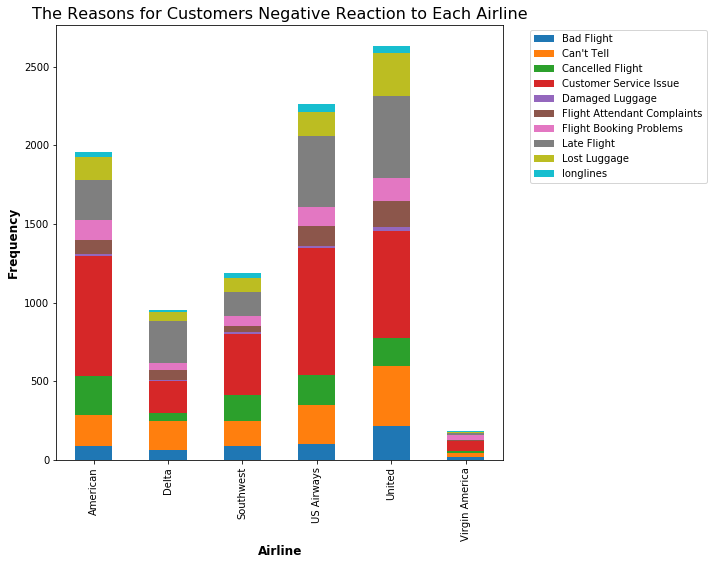

In [19]:
#Visualize reasons for negative reaction per airline
pd.crosstab(data.airline, data.negativereason).plot(kind='bar',figsize=(8,8),stacked=True)
plt.title('The Reasons for Customers Negative Reaction to Each Airline', fontsize=16)
plt.xlabel('Airline', fontsize = 12, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 12, fontweight = 'bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

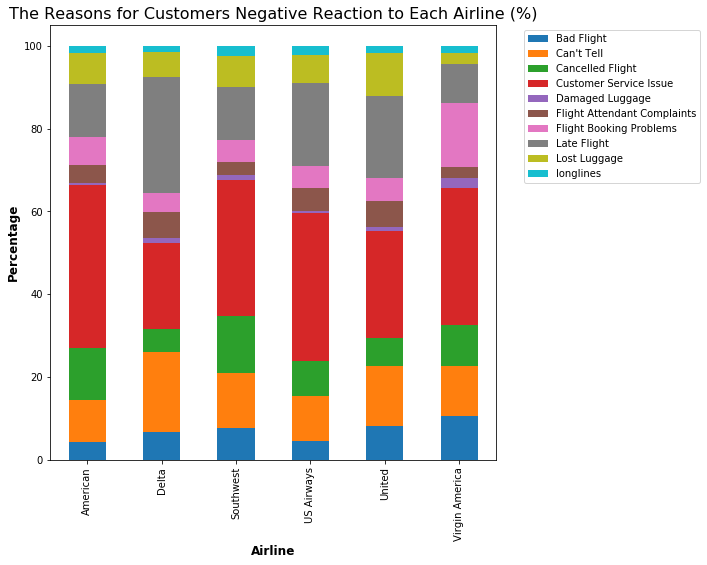

In [20]:
#Visualize reasons for negative reaction per airline (normalized)
pd.crosstab(data.airline, data.negativereason).apply(lambda x: x/x.sum() * 100, axis=1).plot(kind="bar",figsize=(8,8),stacked=True)
plt.title('The Reasons for Customers Negative Reaction to Each Airline (%)', fontsize=16)
plt.xlabel('Airline', fontsize = 12, fontweight = 'bold')
plt.ylabel('Percentage', fontsize = 12, fontweight = 'bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

In [32]:
#The top 5 negative reasons
data.negativereason.value_counts().sort_values(ascending=False).head(5)

Customer Service Issue    2910
Late Flight               1665
Can't Tell                1190
Cancelled Flight           847
Lost Luggage               724
Name: negativereason, dtype: int64

Our dataframe contains tweets posted between 2015-02-16 and 2015-02-24

It will be interesting to see if the date has any effect on the sentiments of the tweets(especially negative)

In [33]:
date = data.reset_index()
#convert the Date column to pandas datetime
date.tweet_created = pd.to_datetime(date.tweet_created)
#Reduce the dates in the date column to only the date and no time stamp using the 'dt.date' method
date.tweet_created = date.tweet_created.dt.date
date.tweet_created.head()
df = date
day_df = df.groupby(['tweet_created','airline','airline_sentiment']).size()

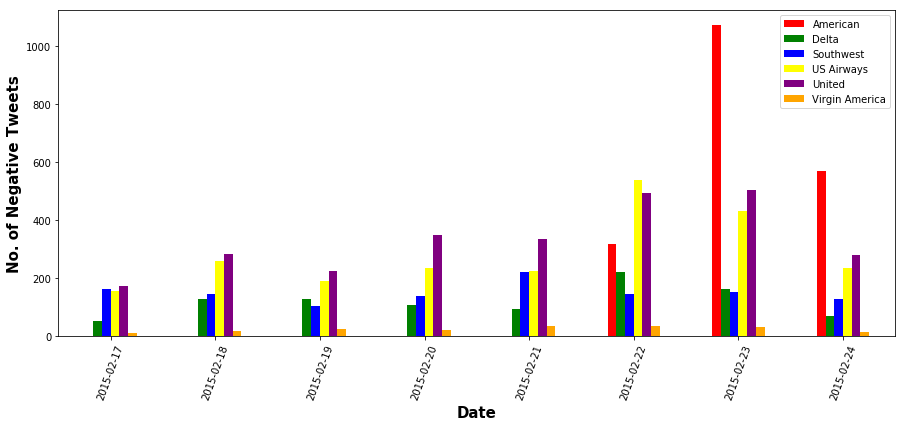

In [38]:
day_df = day_df.loc(axis=0)[:,:,'negative']

#groupby and plot data
ax2 = day_df.groupby(['tweet_created','airline']).sum().unstack().plot(kind = 'bar', color=['red', 'green', 'blue','yellow','purple','orange'], figsize = (15,6), rot = 70)
labels = ['American','Delta','Southwest','US Airways','United','Virgin America']
ax2.legend(labels = labels)
ax2.set_xlabel('Date', fontsize = 15, fontweight = 'bold')
ax2.set_ylabel('No. of Negative Tweets', fontsize = 15, fontweight = 'bold')
plt.show()

Text preprocessing:
- to lowecase
- remove hyperlinks
- remove @mentions
- remove punctuation
- remove numeric
- remove non a-z 0-9 characters and words shorter than 1 characters 

In [39]:
def remove_features(data_str): # compile regex
    url_re = re.compile('https?://(www.)?\w+\.\w+(/\w+)*/?') 
    punc_re = re.compile('[%s]' % re.escape(string.punctuation)) 
    num_re = re.compile('(\\d+)')
    mention_re = re.compile('@(\w+)')
    alpha_num_re = re.compile("^[a-z0-9_.]+$")
    # convert to lowercase
    data_str = data_str.lower()
    # remove hyperlinks
    data_str = url_re.sub(' ', data_str)
    # remove @mentions
    data_str = mention_re.sub(' ', data_str)
    # remove puncuation
    data_str = punc_re.sub(' ', data_str)
    # remove numeric 'words'
    data_str = num_re.sub(' ', data_str)
    # remove non a-z 0-9 characters and words shorter than 1 characters 
    list_pos = 0
    cleaned_str = ''
    for word in data_str.split():
        if list_pos == 0:
            if alpha_num_re.match(word) and len(word) > 1:
                cleaned_str = word 
            else:
                cleaned_str = ' '
        else:
            if alpha_num_re.match(word) and len(word) > 1:
                cleaned_str = cleaned_str + ' ' + word 
            else:
                cleaned_str += ' '
        list_pos += 1
    
    return " ".join(cleaned_str.split())

In [40]:
# Lemmatization
def lemmatize(data_str):
    # expects a string
    list_pos = 0
    cleaned_str = ''
    lmtzr = WordNetLemmatizer() 
    text = data_str.split() 
    tagged_words = pos_tag(text) 
    for word in tagged_words:
        if 'v' in word[1].lower():
            lemma = lmtzr.lemmatize(word[0], pos='v')
        else:
            lemma = lmtzr.lemmatize(word[0], pos='n')
        if list_pos == 0: 
            cleaned_str = lemma
        else:
            cleaned_str = cleaned_str + ' ' + lemma
        list_pos += 1 
    return cleaned_str

In [41]:
# Cleaning Data
data_clean = []
for i in range(len(data)):
    res = remove_features(data['text'][i])
    res1 = lemmatize(res)
    data_clean.append(res1)

In [42]:
data['text'] = data_clean
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,what say,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,plus you ve added commercial to the experience...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,didn today must mean need to take another trip,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,it really aggressive to blast obnoxious entert...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,and it really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Using TextBlob

In this section, we get two outputs, polarity and subjectivity. The polarity score indicates the sentiment score of every tweet. We divide this score into two categories, positive (greater than and equal to 0.0) and negative (smaller than 0.0) and also combine the original positive with the original neutral to form a new positive category. The comparison chart of the new sentiment and the original sentiment is shown below. 
The other score we get from this analysis is subjectivity which indicates how the personal feeling is involved in each tweet but we only utilize the polarity score to determine our new sentiment.

In [43]:
polarity = []
for tweet in data_clean:
    print (tweet)
    analysis = TextBlob(tweet)
    print (analysis.sentiment)
    polarity.append(analysis.sentiment.polarity)

what say
Sentiment(polarity=0.0, subjectivity=0.0)
plus you ve added commercial to the experience tacky
Sentiment(polarity=0.0, subjectivity=0.0)
didn today must mean need to take another trip
Sentiment(polarity=-0.3125, subjectivity=0.6875)
it really aggressive to blast obnoxious entertainment in your guest face amp they have little recourse
Sentiment(polarity=0.0062500000000000056, subjectivity=0.35)
and it really big bad thing about it
Sentiment(polarity=-0.3499999999999999, subjectivity=0.3833333333333333)
seriously would pay flight for seat that didn have this playing it really the only bad thing about fly va
Sentiment(polarity=-0.006666666666666621, subjectivity=0.6866666666666666)
yes nearly every time fly vx this go away
Sentiment(polarity=0.45, subjectivity=0.65)
really missed prime opportunity for men without hat parody there
Sentiment(polarity=0.2, subjectivity=0.2)
well didn now do
Sentiment(polarity=0.0, subjectivity=0.0)
it be amaze and arrive an hour early you re too goo

Sentiment(polarity=1.0, subjectivity=0.3)
can you find u flt out of lax that be sooner than midnight on monday that would be great customer service
Sentiment(polarity=0.8, subjectivity=0.75)
please provide status for flight cant imagine it on time a the web indicate dude to weather here and or dallas
Sentiment(polarity=0.0, subjectivity=0.0)
you have amazing staff amp super helpful a just run the princesshalf they have spoil me with comfort
Sentiment(polarity=0.4666666666666667, subjectivity=0.7833333333333333)
pay the premium to fly you across the country you cancel flight my flight and offer no check fee or upgrade love sad face
Sentiment(polarity=0.26666666666666666, subjectivity=0.8333333333333334)
question be it not possible to book seat for an infant under it not give me the option but we want seat for him
Sentiment(polarity=0.0, subjectivity=1.0)
always have it together you re welcome rt you re so welcome
Sentiment(polarity=0.8, subjectivity=0.9)
flight home to dc sunset globe i

worst unitedflightsever ua la to iad mechanical problem again take off have to land for fix delay again wtfodds
Sentiment(polarity=-1.0, subjectivity=1.0)
despite my bag not make it to newark good informative email track update help
Sentiment(polarity=0.7, subjectivity=0.6000000000000001)
what go on with ua outbound flight last thurs be delay hrs how long will this delay be worst unitedflightsever
Sentiment(polarity=-0.35000000000000003, subjectivity=0.48888888888888893)
worst unitedflightsever ua iad to las mechanical problem switch aircraft delay hour
Sentiment(polarity=-1.0, subjectivity=1.0)
crash try to check in
Sentiment(polarity=0.0, subjectivity=0.0)
wow what deal again plus seat available easy change to make customer happy
Sentiment(polarity=0.43333333333333335, subjectivity=0.8083333333333333)
thanks for the info already know
Sentiment(polarity=0.2, subjectivity=0.2)
airline trouble this winter amp not get good customer service contact we negotiate resolution for you
Sentimen

Sentiment(polarity=0.24999999999999997, subjectivity=0.7)
be do musician real dirty at lax ve never be block from get on flight with my bass
Sentiment(polarity=-0.5249999999999999, subjectivity=0.75)
rebooked now but the line be people deep
Sentiment(polarity=0.0, subjectivity=0.4)
for those play along at home
Sentiment(polarity=0.0, subjectivity=0.0)
yes they say it take more than an hour
Sentiment(polarity=0.5, subjectivity=0.5)
those whose pay to actually fly with you over year deserve better service than cc holder
Sentiment(polarity=0.65, subjectivity=0.7)
ok thank again for your help
Sentiment(polarity=0.5, subjectivity=0.5)
not happy flyer ua flight from sfo to cleveland sunday stay tune for blog article from
Sentiment(polarity=-0.4, subjectivity=1.0)
thanks have question about the wait time for baggage on ua
Sentiment(polarity=0.2, subjectivity=0.2)
flight plane from sfo to den be basically on time
Sentiment(polarity=0.0, subjectivity=0.0)
thanks just program comment the system 

three delayed flight and missed connection on first class flight and not get any compensation for lose those seat
Sentiment(polarity=0.25, subjectivity=0.3333333333333333)
and after be on hold for an hour the day before to sort it out and be tell it fine it should be fine when you arrive to fly
Sentiment(polarity=0.5444444444444444, subjectivity=0.6333333333333333)
it be almost week and still no word from dot on update of london fare to u city any update on your end
Sentiment(polarity=0.0, subjectivity=0.0)
thanks get it straightend out last night
Sentiment(polarity=0.1, subjectivity=0.13333333333333333)
well for start it would be nice if your ticket be actually in the system when you change flight
Sentiment(polarity=0.3, subjectivity=0.55)
any chance flight be be delay nervous about drive to dfw in this weather to drop off my brother
Sentiment(polarity=0.0, subjectivity=0.0)
another awful experience and victoria at the check in desk in stl could not have be more rude and condescend
Se

Sentiment(polarity=-0.30000000000000004, subjectivity=0.55)
be offer to reroute my sfo flight to lax might be geography class time
Sentiment(polarity=0.0, subjectivity=0.0)
thank you for let me down my luggage be still in denver but in phl neveragain flyingwithus disappointed lostacustomer
Sentiment(polarity=-0.4527777777777778, subjectivity=0.5194444444444445)
can you get me on the delayed flight to ewr out of yyz at no customer service to be find in airport
Sentiment(polarity=0.0, subjectivity=0.0)
flight ua after two delay just cancel flightled and no more flight to norfolk that aren book renting car
Sentiment(polarity=-0.25, subjectivity=0.5)
thanks for have no one to pilot my last two flight and all but strand me in houston tonight airline be the absolute worst
Sentiment(polarity=-0.15, subjectivity=0.5416666666666667)
so disgusted and disappointed with united airline luggage policy and attitude toward musician unacceptable
Sentiment(polarity=-0.875, subjectivity=0.875)
miss my am

Sentiment(polarity=0.13333333333333333, subjectivity=0.13333333333333333)
you re customer service be unbelievably bad abysmal ve be on the phone for well over hr tonight hang up on by yr ppl
Sentiment(polarity=-0.6999999999999998, subjectivity=0.6666666666666666)
you can read the full story when submit case to your team about the pilot of flight and why we be sleep in dia
Sentiment(polarity=0.35, subjectivity=0.55)
what with the layover in canada from the ua be that scheduled
Sentiment(polarity=0.0, subjectivity=0.0)
an inconvenience be weather delay your pilot decide to waste enough time so the faa wouldn let him fly be negligence
Sentiment(polarity=0.20000000000000004, subjectivity=0.4666666666666666)
buy ticket with price that be publish by mistake and now get an email that indicate united cancel flightled my ticket why
Sentiment(polarity=0.0, subjectivity=0.0)
new plane wifi not work entertainment non existent new seat seriously uncomfortable really unitedfail ua
Sentiment(polarity

Sentiment(polarity=0.0, subjectivity=0.0)
what the hold up with flight from slc to den
Sentiment(polarity=0.0, subjectivity=0.0)
den phx flight tomorrow cancel flight ask for overnight nite in lax sna tell not without pay that wrong
Sentiment(polarity=-0.5, subjectivity=0.9)
can you please follow for dm
Sentiment(polarity=0.0, subjectivity=0.0)
thank you for the help
Sentiment(polarity=0.0, subjectivity=0.0)
yeah that didn happen
Sentiment(polarity=0.0, subjectivity=0.0)
why do still not have my bag they arrive amp website say they re still at the airport hour late flightr nothappy
Sentiment(polarity=-0.3, subjectivity=0.6)
have maintenance issue stick in geneva with meal voucher that win even cover plate flight of spaghetti really
Sentiment(polarity=0.5, subjectivity=0.30000000000000004)
hate when get bump out of the seat ve select amp empty row and move to another seat non empty flt nonupgrade
Sentiment(polarity=-0.3333333333333333, subjectivity=0.6333333333333333)
no announcement re

Sentiment(polarity=0.0, subjectivity=0.75)
don ask me to be patient without offer something in return
Sentiment(polarity=0.0, subjectivity=0.0)
just like clockwork friday afternoon flight from la to den run late flight why do this seem to happen so consistently keepit
Sentiment(polarity=-0.024999999999999994, subjectivity=0.425)
will on or all of which will be get my business unfriendlyskies unbelievable
Sentiment(polarity=-0.25, subjectivity=1.0)
free booze for the bach party would make it better ord gt msy delay again we will enjoy either way thanks
Sentiment(polarity=0.375, subjectivity=0.5)
have their name board pas be in there too think they might really need this any idea
Sentiment(polarity=0.2, subjectivity=0.2)
sit in seat on flight back from vega to chicago someone leave folder that look important in the seat pocket
Sentiment(polarity=0.2, subjectivity=0.5)
incompetent rude service today miss my connect flight then the customer service desk be terrible to me really upset untd


always make our cross country flight rad here baby flier charlotte thtime monthsold
Sentiment(polarity=0.0, subjectivity=0.0)
too late flight damage have be do easily the worst airline experience of my life miss two connect flight amp day of work ua
Sentiment(polarity=-0.2888888888888889, subjectivity=0.8111111111111112)
don know if you be aware that all of your premier access line be close in your terminal feel the love
Sentiment(polarity=0.375, subjectivity=0.425)
firstclass to london on my way to londonfashionweek lfw
Sentiment(polarity=0.0, subjectivity=0.0)
disappoint to learn you be now charge to use mile for upgrade on p jfk flight will be look at alternative
Sentiment(polarity=0.0, subjectivity=0.0)
just kid with you ll send you my stuff now thanks
Sentiment(polarity=0.2, subjectivity=0.2)
unacceptable practice to leave cancel flighted flight passenger to sleep on cement with no pillow ua
Sentiment(polarity=0.0, subjectivity=0.0)
can get the crew member that we be wait on we be

Sentiment(polarity=0.0, subjectivity=0.0)
how do you log out of wifi in flight don see any option and make typo when logging in help
Sentiment(polarity=0.0, subjectivity=0.0)
when will you have special promotion for flight depart newark nj to st john antigua
Sentiment(polarity=0.35714285714285715, subjectivity=0.5714285714285714)
flight ua from sfo to burbank have be delay twice now still no plane in sight get it together
Sentiment(polarity=0.0, subjectivity=0.0)
just say the truth you don even an email
Sentiment(polarity=0.0, subjectivity=0.0)
mr she on her way now but think id detail the extravaganza for you dobetter please
Sentiment(polarity=0.0, subjectivity=0.0)
hi if premium ec upgrade be pay for amp then mileage bf upgrade do be the prem eco upgrade fare refund
Sentiment(polarity=0.0, subjectivity=0.0)
deaffriendly get there read your review on
Sentiment(polarity=0.0, subjectivity=0.0)
we follow the baggage rule on your website and be still charge but only go one way
Sentiment(p

Sentiment(polarity=0.2, subjectivity=0.2)
you mean like my mailing address and rate by the surliness of my united coworkers guess our benefit aren great
Sentiment(polarity=0.24375000000000002, subjectivity=0.71875)
already send feedback and your rep be who tell me about the priority speechless at your system
Sentiment(polarity=0.0, subjectivity=0.0)
just because you be monopoly in doesn mean you treat your frequent flier like crap
Sentiment(polarity=-0.33749999999999997, subjectivity=0.5958333333333333)
yeah bag be on the way a per usual actually get use to get it deliver to me it kind of nice in sense
Sentiment(polarity=0.2375, subjectivity=0.5625)
how much be baggage check for international flight
Sentiment(polarity=0.1, subjectivity=0.1)
why do it take week for new mileageplus premier card to be send out stillwaiting doesntfeellikestatusyet
Sentiment(polarity=0.13636363636363635, subjectivity=0.45454545454545453)
wonder why people hate deal with airline ridiculous and inflexible pol

cab ride to dfw from love get me my bag reimburse
Sentiment(polarity=0.5, subjectivity=0.6)
unbelievable hypocrisy
Sentiment(polarity=-0.25, subjectivity=1.0)
thanks for not get my businessfirst priority tag bag onto my connect flight at ewr despite hour layover nice job
Sentiment(polarity=0.4, subjectivity=0.6)
amaze fly over mile on unitedairlines amp alliance last year still get jilt out of status moneyelsewhere
Sentiment(polarity=0.4, subjectivity=0.48333333333333334)
on top of this csr go ahead and hang up on me after call unite to discuss this
Sentiment(polarity=0.5, subjectivity=0.5)
now finally in memphis land minute ago still no bag pay for service that just get worse
Sentiment(polarity=-0.2, subjectivity=0.8)
thanks for terrible experience at ewr customer should be treat a priority not a an inconvenience tryagain
Sentiment(polarity=-0.4, subjectivity=0.6)
some rd party service know a ezee flight man who confirm he be bear in india tell me his name be steve wilson
Sentiment(po

Sentiment(polarity=-0.15625, subjectivity=0.84375)
what be the status of the bag check area at ffl
Sentiment(polarity=0.0, subjectivity=0.0)
at least enjoy free cocktail or two
Sentiment(polarity=0.16666666666666666, subjectivity=0.5666666666666668)
agree rt one airline be the fly away favorite at dia newsbusiness
Sentiment(polarity=0.65, subjectivity=0.95)
it flight of that matter to you all hell next we all win get our luggage properly transfer facepalm smh
Sentiment(polarity=0.26666666666666666, subjectivity=0.16666666666666666)
your phone service suck
Sentiment(polarity=0.0, subjectivity=0.0)
my flight at bwi be delay and will miss my flight in denver be there way to find out if they will hold the plane
Sentiment(polarity=0.0, subjectivity=0.0)
airport snow removal method keep up the good work folk this be where cessna become
Sentiment(polarity=0.7, subjectivity=0.6000000000000001)
be people in an exit row still suppose to give their verbal approval be never ask on the flight on
Se

Sentiment(polarity=0.0, subjectivity=0.0)
do anyone realize that ban peanut on flight due to an allergic person ignores nut oil amp dust from previous flight
Sentiment(polarity=-0.14583333333333331, subjectivity=0.2708333333333333)
customer service be rude and bother by our call have no idea what be go on and sigh heavily on the phone unbelievable
Sentiment(polarity=-0.25, subjectivity=0.7000000000000001)
hr late flightr no human interaction end up ing completely new flight so last flight out didn sell out
Sentiment(polarity=-0.04090909090909091, subjectivity=0.3053030303030303)
loses baggage day ago and still have no idea or interest in find it all item for new job in that bag unacceptable
Sentiment(polarity=-0.08181818181818182, subjectivity=0.2772727272727273)
how do get companion pas thanks lin
Sentiment(polarity=0.2, subjectivity=0.2)
just send dm thanks for your attentiveness to this matter
Sentiment(polarity=0.2, subjectivity=0.2)
how about fix the wifi rd flight where it not wo

Sentiment(polarity=0.6125, subjectivity=0.75)
be under the impression when there be an hour delay in your flight because of equipment failure compensation be offer
Sentiment(polarity=-0.3166666666666667, subjectivity=0.3)
can you give me info on flt out of bdl see it cancel flightled
Sentiment(polarity=0.0, subjectivity=0.0)
stick in nyc flight cancel flightled day in row long wait time on phone run out of but swa no help
Sentiment(polarity=-0.05, subjectivity=0.4)
do you ever reinstate cancel flighted flight
Sentiment(polarity=0.0, subjectivity=0.0)
great example of customer service this morning at msy head to atl alison and bobbi be fantastic gate thank you
Sentiment(polarity=0.6000000000000001, subjectivity=0.825)
run out of money to keep pay for hotel room amp food in nyc you don help people with spent
Sentiment(polarity=-0.1, subjectivity=0.1)
flight cancel flightled try to get refund but on hold can get it after my flight would have depart
Sentiment(polarity=0.0, subjectivity=0.0

Sentiment(polarity=0.0, subjectivity=0.0)
need refund on my cancel flightled flight this morning and have be on hold for more than an hour what to do
Sentiment(polarity=0.5, subjectivity=0.5)
thanks for the cancelled flightation today only airline that cancel flight lose customer today
Sentiment(polarity=0.1, subjectivity=0.6)
cancel flightling flight due to winter weather be totally understandable but it would sure be nice if you would answer your phone
Sentiment(polarity=0.24375, subjectivity=0.7534722222222222)
can book flight on my own and get reimburse by you
Sentiment(polarity=0.6, subjectivity=1.0)
ve be on hold for hr now wait to talk to someone with pulse to get my cancel flighted flight reschedule be this sop
Sentiment(polarity=0.0, subjectivity=0.0)
be on hold to rebook flight to cmh for hr your rebook website be crash
Sentiment(polarity=0.0, subjectivity=0.0)
be on hold so long to rebook my cancel flightled flight have enough time to rebook with instead lot of room there
Se

love ya but your bringin me down an hour late flight leave and now we ve be sit in the runway for min fail
Sentiment(polarity=-0.11388888888888889, subjectivity=0.4472222222222222)
have never be mor disappoint in company charge to use your wifi which only work for about apps parhetic
Sentiment(polarity=0.0, subjectivity=1.0)
just pick up my bag at seatac all the clothes be soak wet bagawim
Sentiment(polarity=-0.1, subjectivity=0.4)
would be cool if the best airline company hook me up with ticket for vega
Sentiment(polarity=0.675, subjectivity=0.475)
appreciate the reply hopefully those lax agent get the memo cheer
Sentiment(polarity=0.0, subjectivity=0.0)
can you help me out with ticket to the vega event would be so stoked
Sentiment(polarity=0.0, subjectivity=0.0)
notice that there be separate button for guitar and actual music in this pic some band should take note of this
Sentiment(polarity=0.0, subjectivity=0.1)
give me ticket to atlanta would do anything anything
Sentiment(polarity

Sentiment(polarity=0.30000000000000004, subjectivity=0.55)
appreciate the reply rt so sorry to keep you wait laura an agent will be with you shortly cb
Sentiment(polarity=-0.25, subjectivity=0.65)
book our flight this morning can wait to move about the country
Sentiment(polarity=0.0, subjectivity=0.0)
love you guy have to take few other airline this week make me love and appreciate all so much more onlywaytofly
Sentiment(polarity=0.23500000000000001, subjectivity=0.43499999999999994)
get leathery from the heat on before even get to vegas
Sentiment(polarity=0.0, subjectivity=0.0)
my first flight ever and flight be already have technical issue faaaannntastic
Sentiment(polarity=0.125, subjectivity=0.21666666666666667)
try to get to mexico in september how about affordable nonstop flight
Sentiment(polarity=0.0, subjectivity=0.0)
how it feel on flight
Sentiment(polarity=0.0, subjectivity=0.0)
think me and my group could use some nice cold drink once we get in the air we be all over
Sentimen

Sentiment(polarity=0.0, subjectivity=0.0)
so today call into customer service amp speak with wendell holton in the dallas office amp be tell there be nothing he can do
Sentiment(polarity=0.0, subjectivity=0.0)
we do not get single answer from any southwest personnel after an hour wait no apologies no explanation
Sentiment(polarity=-0.07142857142857142, subjectivity=0.21428571428571427)
along with other passenger repeatedly ask southwest personnel what be take so long where be our luggage
Sentiment(polarity=-0.0875, subjectivity=0.3875)
take delivery of new boeing yesterday dfw dal airline
Sentiment(polarity=0.13636363636363635, subjectivity=0.45454545454545453)
next once we arrive to atlanta we wait full hour before our luggage be place on carousel one hour
Sentiment(polarity=0.175, subjectivity=0.275)
secondly we do not begin board on time despite our aircraft be present and deplaned thus we leave over min late flight
Sentiment(polarity=-0.09999999999999999, subjectivity=0.19999999999

Sentiment(polarity=-0.125, subjectivity=0.375)
you need to be more accommodate to your loyal customer not happy now
Sentiment(polarity=0.1444444444444444, subjectivity=0.7777777777777778)
yes thank you oct oct
Sentiment(polarity=0.0, subjectivity=0.0)
do eventually get through but that flight cancel flightled decide to drive but give up hold to process refund
Sentiment(polarity=0.0, subjectivity=0.0)
already rebooked for tomorrow finger cross
Sentiment(polarity=0.0, subjectivity=0.0)
follow
Sentiment(polarity=0.0, subjectivity=0.0)
worst customer service terrible attitude don care how big storm your employee need an attitude adjustment
Sentiment(polarity=-0.6666666666666666, subjectivity=0.7000000000000001)
or you could send me dm
Sentiment(polarity=0.0, subjectivity=0.0)
be follow you now don think can dm until you follow me
Sentiment(polarity=0.0, subjectivity=0.0)
flight cancel flightled out of bna do have to reschedule now or can travel fund be put back into my account for future u

Sentiment(polarity=0.0, subjectivity=0.0)
our fleet on fleek wtf
Sentiment(polarity=-0.5, subjectivity=1.0)
lol our fleet on fleek
Sentiment(polarity=0.8, subjectivity=0.7)
our fleet on fleek freberg
Sentiment(polarity=0.0, subjectivity=0.0)
noooo don do it please don do it our fleet on fleek
Sentiment(polarity=0.0, subjectivity=0.0)
our fleet on fleek lol wut
Sentiment(polarity=0.8, subjectivity=0.7)
rt our fleet on fleek
Sentiment(polarity=0.0, subjectivity=0.0)
our fleet on fleek lmfaooooo hook me up with flight
Sentiment(polarity=0.0, subjectivity=0.0)
our fleet on fleek
Sentiment(polarity=0.0, subjectivity=0.0)
indeed it be not
Sentiment(polarity=0.0, subjectivity=0.0)
we have some major plane wide directtv issue yesterday system keep be reset by crew member
Sentiment(polarity=-0.018750000000000003, subjectivity=0.45)
not help since there bunch of u try to get off at the same time
Sentiment(polarity=0.0, subjectivity=0.125)
need to get my yr old to nassau from sea to meet her grea

be your partnership with hawaiian live earn hawaiian mile fly jetblue if so how do add to my jb flight booking problem
Sentiment(polarity=0.4681818181818182, subjectivity=0.7)
you leave people on hot plane with no ventilation for over an hour and half and then have to bus them to jfk because of
Sentiment(polarity=0.04166666666666667, subjectivity=0.5083333333333334)
at what point in delay can take different flight to my destination
Sentiment(polarity=0.0, subjectivity=0.6)
thank you guy you be the best
Sentiment(polarity=1.0, subjectivity=0.3)
you just don get it it not about the money it about people how about public apology from the president of jet blue
Sentiment(polarity=0.0, subjectivity=0.08333333333333334)
why when you book flight now do jetblue separate yr old from the mother isn that bite stupid check in headache
Sentiment(polarity=-0.35, subjectivity=0.6)
do not fit in
Sentiment(polarity=-0.2, subjectivity=0.4)
love it a always
Sentiment(polarity=0.5, subjectivity=0.6)
you ne

Sentiment(polarity=1.0, subjectivity=1.0)
can bring compact fold chair like this in checked bag
Sentiment(polarity=0.0, subjectivity=0.0)
quick why be person travel mosaic not get the green tag doesn make sense end up waitin my son bag anyway
Sentiment(polarity=0.06666666666666665, subjectivity=0.4)
get it wish they would communicate more u
Sentiment(polarity=0.5, subjectivity=0.5)
continue you record of never have flight leave on time add up how much time with with my family you have cost me jetblue
Sentiment(polarity=0.2, subjectivity=0.2)
use jetblue mile
Sentiment(polarity=0.0, subjectivity=0.0)
guess have to redo the flight book problem ugh
Sentiment(polarity=0.0, subjectivity=0.0)
that suck oh well
Sentiment(polarity=0.0, subjectivity=0.0)
she stand here on her cell no announcements no info thismosaicnothappy
Sentiment(polarity=0.0, subjectivity=0.0)
use jetblue air mile
Sentiment(polarity=0.0, subjectivity=0.0)
someone be here but have no info smh one bag come off and then nothi

Sentiment(polarity=-0.05, subjectivity=0.4)
thanks for your help jetbluesofly
Sentiment(polarity=0.2, subjectivity=0.2)
be able to access it by use the drop down instead of click on the tab
Sentiment(polarity=0.17222222222222222, subjectivity=0.4569444444444445)
do your trueblue page not work on chrome or safari keep get blank page when lick on the trueblue tab on your site
Sentiment(polarity=0.0, subjectivity=0.0)
ahoy from loyal allyoucanjetpass holder when do you anticipate direct u flight to havana cuba jetblue vacation
Sentiment(polarity=0.21666666666666667, subjectivity=0.6166666666666667)
that be my point they be only offer me flight the next day and expect me to now pay for hotel because they cancel flightled
Sentiment(polarity=0.0, subjectivity=0.5)
excite for my first flight you today it delay though can you give me the flight number from boston to dc
Sentiment(polarity=0.25, subjectivity=0.3333333333333333)
what be the mosiac
Sentiment(polarity=0.0, subjectivity=0.0)
can pro

Sentiment(polarity=0.7, subjectivity=0.55)
only middle seat sfo gt bos not fun she keep get credit would much rather have work tv
Sentiment(polarity=0.012500000000000004, subjectivity=0.35)
disappoint we weren allow to bring on an aircraft approve carseat on an empty plane not cool
Sentiment(polarity=-0.1375, subjectivity=0.575)
beatriz and susan gate mco
Sentiment(polarity=0.0, subjectivity=0.0)
handle question like social medium pro good practice for when our transportation system be all run by friendly ai
Sentiment(polarity=0.36944444444444446, subjectivity=0.3888888888888889)
maybe have supervisor find out why the international checkin at ftl hasn move in minute yet employee pick up pizza
Sentiment(polarity=0.0, subjectivity=0.0)
third flight in row for my wife with her tv not work
Sentiment(polarity=0.0, subjectivity=0.0)
it wonderful thing
Sentiment(polarity=1.0, subjectivity=1.0)
what be personal email that can contact have complaint that you should know about
Sentiment(polarity

Sentiment(polarity=0.0, subjectivity=0.0)
what the charge for oversize not overweight
Sentiment(polarity=0.0, subjectivity=0.0)
to my legal last name so it not technically name change just use the wrong name
Sentiment(polarity=-0.075, subjectivity=0.31666666666666665)
an award travel ticket but cannot since it be under different last name simply need to change it
Sentiment(polarity=0.0, subjectivity=0.3412698412698412)
hi on my dividend mile account accidentally list my newly marry name a oppose to my legal name be try to book
Sentiment(polarity=0.16818181818181818, subjectivity=0.32727272727272727)
ok thank call from spain to u for seat assistance
Sentiment(polarity=0.5, subjectivity=0.5)
can check bag through to my final destination even though buy separate ticket from iad to phl and phl to israel
Sentiment(polarity=0.0, subjectivity=1.0)
day no coffee amp work toilet then read domestic airline whine re foreign competition coincidence no openskies
Sentiment(polarity=-0.05277777777777

go to manchester uk now go to miss wedding you go to rebook that too why have you choose to cancel flight my flight
Sentiment(polarity=0.0, subjectivity=0.0)
if you dm me we can take this offline would love more info on location of lose bag any help be appreciate
Sentiment(polarity=0.5, subjectivity=0.55)
thanx but this isn my first rodeo do amp do yesterday no result or comm unless count status bag lose amp claim file
Sentiment(polarity=0.25, subjectivity=0.3333333333333333)
can you give me for u air in philly to talk to real person acarl com
Sentiment(polarity=0.2, subjectivity=0.30000000000000004)
would have be nice to be offer in flight credit especially since star at empty overhead room
Sentiment(polarity=0.16666666666666666, subjectivity=0.8333333333333334)
or how about power outlet at your seat if you re gonna keep u sit here forever
Sentiment(polarity=0.0, subjectivity=0.0)
would appreciate call regard horrible experience have with gate agent be on hold for min and then hung on

Sentiment(polarity=0.02083333333333333, subjectivity=0.35416666666666663)
but good luck get there not cool
Sentiment(polarity=0.26249999999999996, subjectivity=0.625)
leave an item on plane bos phl on friday ve call phl u airways amp leave msg no return call what to do at this point
Sentiment(polarity=0.0, subjectivity=0.0)
what great way to kick someone when they be down cancelled flight noon flight and rebook me on one two hour south from here tomorrow
Sentiment(polarity=0.32222222222222224, subjectivity=0.5194444444444445)
thanks for make me check my bag when the space be empty and to the flight attendant for the dirty look
Sentiment(polarity=-0.07499999999999998, subjectivity=0.47500000000000003)
so apparently all of your computer crash at bwi any update on when flight will be move
Sentiment(polarity=0.05, subjectivity=0.35)
make it to the bahamas for work but my luggage didn know travel happens but be there anyway can get more help info
Sentiment(polarity=0.5, subjectivity=0.5)
hr

download jeokoo the american app for air traveler
Sentiment(polarity=0.0, subjectivity=0.0)
obviously your corporate definition of patience need to be review pleasehurryup answerphone reschedulemyflight
Sentiment(polarity=0.0, subjectivity=0.25)
need help with flight weather funeral tough combination on hold for over an hour please
Sentiment(polarity=-0.3888888888888889, subjectivity=0.8333333333333334)
ve be on hold since pm how many customer service rep do you have seriously
Sentiment(polarity=0.08333333333333334, subjectivity=0.5833333333333333)
well if you really didn like them then she would be on an airplane fiousairways
Sentiment(polarity=0.2, subjectivity=0.2)
yes be a well five hour on hold folk can you please tell me if this be typical try to be understand here
Sentiment(polarity=-0.16666666666666666, subjectivity=0.5)
can you please train your mechanic teach them to bring the tool to fix the plane with them and not leave them in the hanger
Sentiment(polarity=0.0, subjectivit

Sentiment(polarity=0.0, subjectivity=0.0)
bad plane amp gate change lot of exercise travelfail let hope this plane work tire
Sentiment(polarity=-0.6999999999999998, subjectivity=0.6666666666666666)
good info but be already sign up for all option none of which sound like they apply to the miss email
Sentiment(polarity=0.55, subjectivity=0.5)
be there not faster way to get me to columbia sc than make me stay in clt over night after my delayed flight
Sentiment(polarity=0.0, subjectivity=0.0)
thank you
Sentiment(polarity=0.0, subjectivity=0.0)
and please get my plane together before go to jetblue
Sentiment(polarity=0.0, subjectivity=0.0)
it might have go through no confirmation please wait then same form
Sentiment(polarity=0.0, subjectivity=0.125)
find the tix security code not work try dozen time
Sentiment(polarity=0.0, subjectivity=0.0)
nightmarish customer service further to that a an elite member appal
Sentiment(polarity=0.0, subjectivity=0.5)
have never be give number for elite for us

Sentiment(polarity=0.0, subjectivity=0.0)
appreciate the call when flight delay but the recorded msg be tedious amp just go on amp on vote for text if practical
Sentiment(polarity=-0.5, subjectivity=1.0)
horrible communication on delayed flight out of lga get email in second different delay time horrible
Sentiment(polarity=-0.5, subjectivity=0.65)
thank you finally get our bag customer service rep be wonderful
Sentiment(polarity=0.5, subjectivity=1.0)
have pm flight out of phl sit snow expect be we able to switch to an earlier flight without penalty
Sentiment(polarity=0.25, subjectivity=0.5625)
we get our bag today thanks
Sentiment(polarity=0.2, subjectivity=0.2)
min hold time then hang up by manager mike in dividend mile dept tough to justify stick with the u air cc and status
Sentiment(polarity=-0.3888888888888889, subjectivity=0.8333333333333334)
never fail to disappoint
Sentiment(polarity=0.25, subjectivity=0.29999999999999993)
platinum flyer buy tkt in aa also both account be link

that the flight be place on after original flight to charlotte be cancel flightled now be on hr delay
Sentiment(polarity=0.375, subjectivity=0.75)
thx to gate agt john pascucci for find u flight from clt to pvd after our original one be cancel flightled
Sentiment(polarity=0.375, subjectivity=0.75)
st reaccommodation now delay flight for this one amp the gate agent still hasn mumble word folk get anxious
Sentiment(polarity=-0.25, subjectivity=1.0)
you be the best follow me please
Sentiment(polarity=1.0, subjectivity=0.3)
please don go to the check in process us at mco it an absolute disaster
Sentiment(polarity=0.2, subjectivity=0.9)
how about phone to talk to real person
Sentiment(polarity=0.2, subjectivity=0.30000000000000004)
over week since you take our money and leave u strand hour from home have to rent car and you still have not help u
Sentiment(polarity=0.0, subjectivity=0.0)
give up
Sentiment(polarity=0.0, subjectivity=0.0)
ve be on hold for one hour and four minute for your res

second from touchdown at madrid airport in april avgeek
Sentiment(polarity=0.0, subjectivity=0.0)
slept in the miami airport due to mechanical issue and be give bonus mile to try and make it right slapintheface
Sentiment(polarity=0.08035714285714285, subjectivity=0.45535714285714285)
be the new time confirm or it may get cancel flightled travel with kid need to be certain thx
Sentiment(polarity=0.17532467532467533, subjectivity=0.512987012987013)
hr min cost of flight change be hr ago drop call cancel flighted flight ask refund
Sentiment(polarity=0.0, subjectivity=0.0)
it not just frustrate it be pay for how do we get refund
Sentiment(polarity=0.0, subjectivity=0.0)
dm the locator code thanks
Sentiment(polarity=0.2, subjectivity=0.2)
thank you
Sentiment(polarity=0.0, subjectivity=0.0)
sure hope you all can fix good luck their service suck nexttimeiwillflysouthwest
Sentiment(polarity=0.6, subjectivity=0.7444444444444445)
thanks for no fresh food on my cross country flight and for make m

Sentiment(polarity=0.8, subjectivity=0.9)
nothing to do with mother nature more like poor commutation
Sentiment(polarity=0.04999999999999999, subjectivity=0.55)
be the worst airline in the entire world only fly them because have to and it be the nightmare know it would be
Sentiment(polarity=-0.04999999999999999, subjectivity=0.88125)
hey have name issue on my reservation can you help
Sentiment(polarity=0.0, subjectivity=0.0)
dm you
Sentiment(polarity=0.0, subjectivity=0.0)
thank you my lost item be locate at ord and be be return to me
Sentiment(polarity=0.0, subjectivity=0.0)
why doesn provide mean for dialogue what be the fear that drive this decision worstcustomerserviceever
Sentiment(polarity=-0.3125, subjectivity=0.6875)
four hour late flightrs and we be finally fly out too bad miss my event
Sentiment(polarity=-0.06666666666666661, subjectivity=0.7222222222222222)
please allow me to speak with someone dialogue would solve this issue better and faster than email
Sentiment(polarity=0

Sentiment(polarity=0.7, subjectivity=0.6000000000000001)
welcome anyone who work in those condition deserve thank you even though be other side of atlantic lol xx
Sentiment(polarity=0.4916666666666667, subjectivity=0.6583333333333333)
could you check if there be swu typo in last post space on aa mxp jfk feb th thanks
Sentiment(polarity=0.1, subjectivity=0.13333333333333333)
could you check if there be svu space on aa mxp jfk feb th thanks
Sentiment(polarity=0.2, subjectivity=0.2)
thanks gang mind if ask do you handle all of your social medium in house
Sentiment(polarity=0.11666666666666667, subjectivity=0.13333333333333333)
sure be what more frustrating be be strand at the airport with our fate in your hand
Sentiment(polarity=0.19999999999999998, subjectivity=0.762962962962963)
thanks for tell me my flight get cancel flightled when it wasn now have miss luggage because of you thank fam
Sentiment(polarity=0.2, subjectivity=0.2)
yes have thanks
Sentiment(polarity=0.2, subjectivity=0.2)
m

Sentiment(polarity=0.0, subjectivity=0.0)
so far all be get be maybe your bag will come today we don know website say status unknown can you help
Sentiment(polarity=0.0, subjectivity=0.8)
my flight be cancel flightled need to be rebooked and can do it online and they aren answer call help
Sentiment(polarity=0.0, subjectivity=0.0)
fill out that whole form before receive poor poor response be there no direct email address in reply
Sentiment(polarity=-0.16250000000000003, subjectivity=0.5)
it the abc of pr let your customer have the most info possible might want to go brush up on the basic
Sentiment(polarity=0.16666666666666666, subjectivity=0.5416666666666666)
last trip on poor customer service trip in row here come
Sentiment(polarity=-0.2, subjectivity=0.3333333333333333)
stiiiil wait please respond a my flight leave in hr
Sentiment(polarity=0.0, subjectivity=0.0)
no worry love fly with you guy thanks
Sentiment(polarity=0.5, subjectivity=0.5666666666666667)
you have the worst rep at jac

lose luggage on flight yesterday morning miami to newyork lga no response and no luggage more than hr ltr
Sentiment(polarity=0.5, subjectivity=0.5)
wow that helpful
Sentiment(polarity=0.1, subjectivity=1.0)
at the gate when get off the plane
Sentiment(polarity=0.0, subjectivity=0.0)
can you take care please thanks
Sentiment(polarity=0.2, subjectivity=0.2)
those be very beautiful photo thx would market dept be interested in buy
Sentiment(polarity=0.625, subjectivity=0.75)
no worry you re swamp know just dmd back thank
Sentiment(polarity=0.0, subjectivity=0.0)
we make it so no worry you guy do good tonight and even put on my flight firstclass
Sentiment(polarity=0.7, subjectivity=0.6000000000000001)
by answer a fast a they can you mean hang up on every call
Sentiment(polarity=-0.056249999999999994, subjectivity=0.64375)
but at least your automated message give me info about your merger another airline know to avoid
Sentiment(polarity=-0.3, subjectivity=0.4)
do hope you can offer something

Sentiment(polarity=0.0, subjectivity=0.0)
a be but thankfully there be lounge next door really not impress by oneworld partnership
Sentiment(polarity=-0.05, subjectivity=0.1)
delay wow
Sentiment(polarity=0.1, subjectivity=1.0)
my flt aa for get cncled and cant get hold of csr so can get alternate arrangement plz help
Sentiment(polarity=0.0, subjectivity=0.0)
our flight be cancel flightled and rebooked to unite you didn give them accurate ticket number now we can check in annoyed
Sentiment(polarity=2.7755575615628914e-17, subjectivity=0.7166666666666668)
you guy be totally lose me ve be an aa fan for year but tell me rep be busy and hang up on me be really bad
Sentiment(polarity=-0.19999999999999996, subjectivity=0.5722222222222223)
aa min for priority bag to arrive now late flight for even plan delta min bag guarantee anyone
Sentiment(polarity=-0.3, subjectivity=0.6)
sit in hour long at least phone queue hop get thing rebooked in time or at least some plastic wing tear
Sentiment(polari

In [45]:
# Compare original sentiment with polarity
df['polarity'] = pd.DataFrame(polarity)
df['sentiment'] = np.where(df['polarity'] < 0.0, 1, 0)
df['sentiment_orig'] = np.where(df['airline_sentiment']=='negative', 1, 0)
df['clean_text'] = data_clean

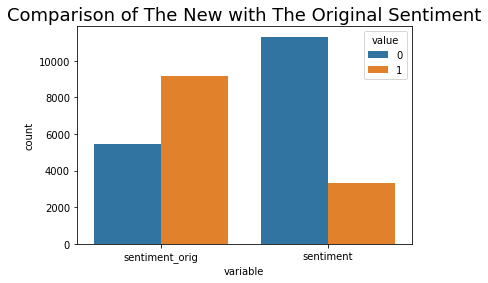

In [59]:
sns.countplot(x="variable", hue="value", data=pd.melt(df[['sentiment_orig', 'sentiment']]))
plt.title('Comparison of The New with The Original Sentiment', fontsize=18)
plt.show()

### Word Cloud

We will create three word clouds using the cleaned text:
1. Using all words in the cleaned text.
2. Using only the positive words based on our own sentiment analysis.
3. Using the negative words based on our own sentiment analysis.

In [47]:
wc_string = data['text'].str.cat(sep=' ')

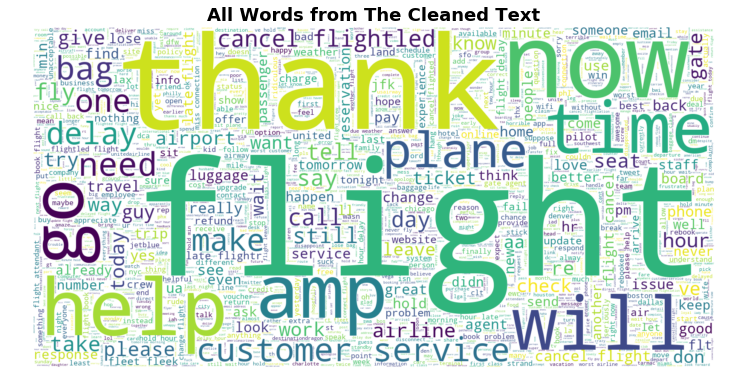

In [49]:
wc = WordCloud(width=1600, height=800,background_color="white", max_words=2000).generate(wc_string)
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('All Words from The Cleaned Text', fontsize=18, fontweight = 'bold')
plt.show()

- Positive Sentiment

In [50]:
pos_string = df[df.sentiment == 0]['clean_text'].str.cat(sep=' ')

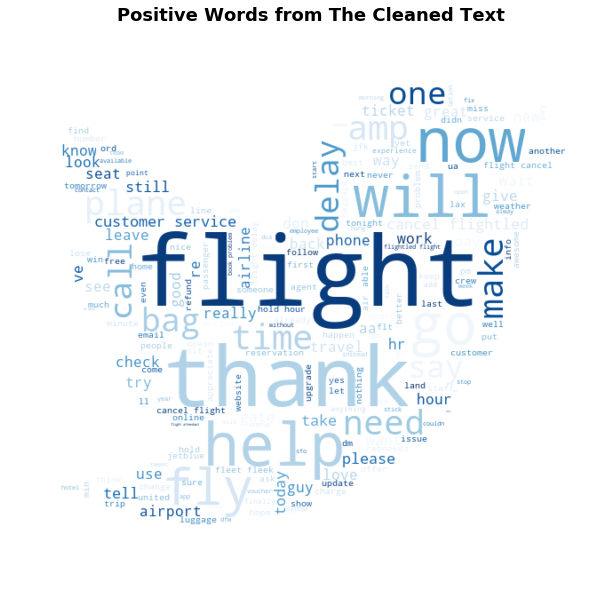

In [52]:
twitter_mask = np.array(Image.open("/Users/shalinisingh/Desktop/Projects/USAirlines_twitter/social-twitter-bird-symbol_318-27588.jpg"))
wc = WordCloud(width=1600, height=800,background_color="white", colormap="Blues",mask=twitter_mask).generate(pos_string)
plt.figure(figsize=(8,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Positive Words from The Cleaned Text', fontsize=18, fontweight = 'bold')
plt.show()

In [53]:
neg_string = df[df.sentiment == 1]['clean_text'].str.cat(sep=' ')

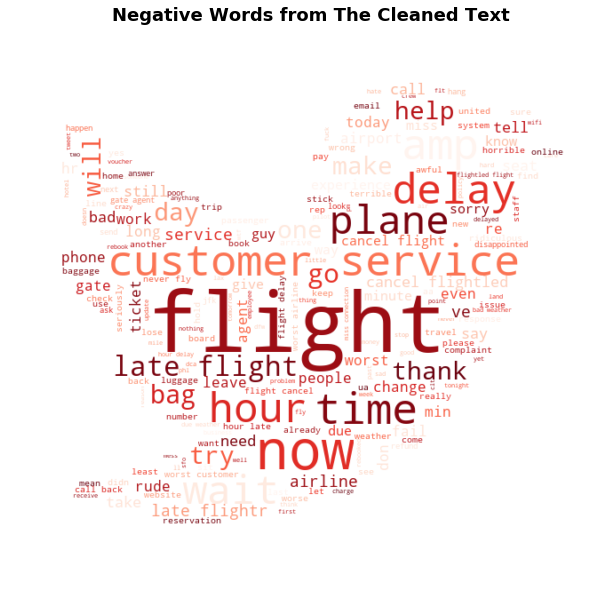

In [54]:
twitter_mask = np.array(Image.open("/Users/shalinisingh/Desktop/Projects/USAirlines_twitter/social-twitter-bird-symbol_318-27588.jpg"))
wc = WordCloud(width=1600, height=800,background_color="white", colormap="Reds",mask=twitter_mask).generate(neg_string)
plt.figure(figsize=(8,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Negative Words from The Cleaned Text', fontsize=18, fontweight = 'bold')
plt.show()

### Text Classification Models

The final step is the Model Building step in which a machine learning model is trained on a labelled dataset

In [47]:
df['Sentiment'] = np.where(df['sentiment'] == 1, 'negative', 'positive')

In [48]:
df['Sentiment'].value_counts()

positive    11314
negative     3326
Name: Sentiment, dtype: int64

Prepare the data for modeling:
* Split the data into training and test sets. You should have four sets of data - X_train, X_test, y_train, y_test

In [49]:
 # split the data into inputs and outputs 
X = df.clean_text # inputs into model
Y = df.Sentiment # output of model

In [52]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Create numerical features:
* Count Vectorizer: Terms should be unigrams (single words), and values should be word counts
* TF-IDF Vectorizer

In [55]:
cv = CountVectorizer(stop_words='english')
X_train_cv = cv.fit_transform(X_train) # fit_transform learns the vocab and one-hot encodes
X_test_cv = cv.transform(X_test) # transform uses the same vocab and one-hot encodes
# print the dimensions of the training set (text messages, terms)
print(X_train_cv.toarray().shape)

(11712, 8199)


In [56]:
X_train_cv = pd.DataFrame(X_train_cv.toarray(), columns=cv.get_feature_names())
X_test_cv = pd.DataFrame(X_test_cv.toarray(), columns=cv.get_feature_names())

In [57]:
tv = TfidfVectorizer(stop_words="english")
X_train_tv = tv.fit_transform(X_train) # fit_transform learns the vocab and one-hot encodes
X_test_tv = tv.transform(X_test) # transform uses the same vocab and one-hot encodes
print(X_train_tv.toarray().shape)

(11712, 8199)


In [58]:
X_train_tv = pd.DataFrame(X_train_tv.toarray(), columns=tv.get_feature_names())
X_test_tv = pd.DataFrame(X_test_tv.toarray(), columns=tv.get_feature_names())

### 1. Naive Bayes

In [61]:
nb = MultinomialNB()
# Train the model
nb.fit(X_train_cv, Y_train)
# Take the model that was trained on the X_train_cv data and apply it to the X_test_cv data
y_pred_cv_nb = nb.predict(X_test_cv)
y_pred_cv_nb

array(['positive', 'positive', 'positive', ..., 'positive', 'positive',
       'positive'], dtype='<U8')

Accuracy: 0.864
Precision: 0.871
Recall: 0.965
F1 Score: 0.916


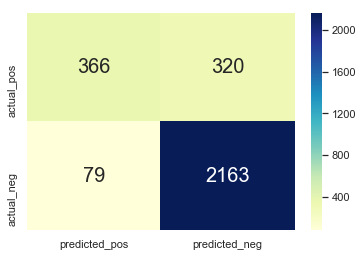

In [62]:
cm = confusion_matrix(Y_test, y_pred_cv_nb)
sns.heatmap(cm, xticklabels=['predicted_pos', 'predicted_neg'], yticklabels=['actual_pos', 'actual_neg'], annot=True, fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
true_neg, false_pos = cm[0]
false_neg, true_pos = cm[1]
accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
precision = round((true_pos) / (true_pos + false_pos),3)
recall = round((true_pos) / (true_pos + false_neg),3)
f1 = round(2 * (precision * recall) / (precision + recall),3)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F1 Score: {}'.format(f1))

In [63]:
nb = MultinomialNB()
# Train the model
nb.fit(X_train_tv, Y_train)
# Take the model that was trained on the X_train_cv data and apply it to the X_test_cv data
y_pred_tv_nb = nb.predict(X_test_tv)
y_pred_tv_nb

array(['positive', 'positive', 'positive', ..., 'positive', 'positive',
       'positive'], dtype='<U8')

Accuracy: 0.794
Precision: 0.789
Recall: 0.998
F1 Score: 0.881


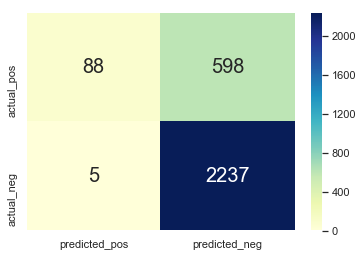

In [64]:
cm = confusion_matrix(Y_test, y_pred_tv_nb)
sns.heatmap(cm, xticklabels=['predicted_pos', 'predicted_neg'], yticklabels=['actual_pos', 'actual_neg'], annot=True, fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
true_neg, false_pos = cm[0]
false_neg, true_pos = cm[1]
accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
precision = round((true_pos) / (true_pos + false_pos),3)
recall = round((true_pos) / (true_pos + false_neg),3)
f1 = round(2 * (precision * recall) / (precision + recall),3)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F1 Score: {}'.format(f1))

### 2. Logistic Regression

In [66]:
 # Use a logistic regression model
lr = LogisticRegression()
# Train the model
lr.fit(X_train_cv, Y_train)
# Take the model that was trained on the X_train_cv data and apply it to the X_test_cv data
y_pred_cv = lr.predict(X_test_cv)
y_pred_cv

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array(['positive', 'positive', 'positive', ..., 'positive', 'positive',
       'positive'], dtype=object)

Accuracy: 0.888
Precision: 0.892
Recall: 0.971
F1 Score: 0.93


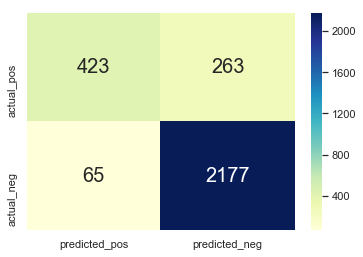

In [67]:
cm = confusion_matrix(Y_test, y_pred_cv)
sns.heatmap(cm, xticklabels=['predicted_pos', 'predicted_neg'], yticklabels=['actual_pos', 'actual_neg'], annot=True, fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
true_neg, false_pos = cm[0]
false_neg, true_pos = cm[1]
accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
precision = round((true_pos) / (true_pos + false_pos),3)
recall = round((true_pos) / (true_pos + false_neg),3)
f1 = round(2 * (precision * recall) / (precision + recall),3)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F1 Score: {}'.format(f1))

In [68]:
# Train the model
lr.fit(X_train_tv, Y_train)
# Take the model that was trained on the X_train_cv data and apply it to the X_test_cv data
y_pred_tv = lr.predict(X_test_tv)
y_pred_tv

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array(['positive', 'positive', 'positive', ..., 'positive', 'positive',
       'positive'], dtype=object)

Accuracy: 0.864
Precision: 0.859
Recall: 0.985
F1 Score: 0.918


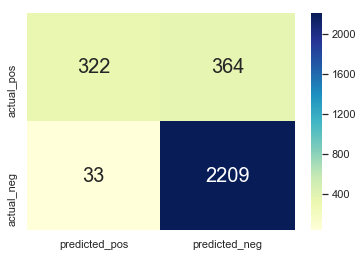

In [69]:
cm = confusion_matrix(Y_test, y_pred_tv)
sns.heatmap(cm, xticklabels=['predicted_pos', 'predicted_neg'], yticklabels=['actual_pos', 'actual_neg'], annot=True, fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
true_neg, false_pos = cm[0]
false_neg, true_pos = cm[1]
accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
precision = round((true_pos) / (true_pos + false_pos),3)
recall = round((true_pos) / (true_pos + false_neg),3)
f1 = round(2 * (precision * recall) / (precision + recall),3)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F1 Score: {}'.format(f1))

### 3. Support Vector Machine

In [72]:
# Running SVM for Count Vectorizer
svclassifier = SVC(kernel='linear', C=0.1, gamma = 0.1)  
svclassifier.fit(X_train_cv, Y_train)
y_pred_cv = svclassifier.predict(X_test_cv)

Accuracy: 0.882
Precision: 0.885
Recall: 0.971
F1 Score: 0.926


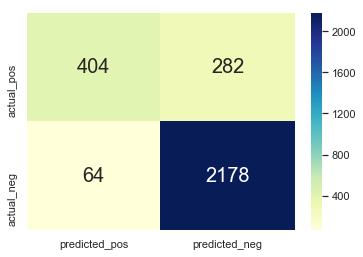

In [73]:
cm = confusion_matrix(Y_test, y_pred_cv)
sns.heatmap(cm, xticklabels=['predicted_pos', 'predicted_neg'], yticklabels=['actual_pos', 'actual_neg'], annot=True, fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
true_neg, false_pos = cm[0]
false_neg, true_pos = cm[1]
accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
precision = round((true_pos) / (true_pos + false_pos),3)
recall = round((true_pos) / (true_pos + false_neg),3)
f1 = round(2 * (precision * recall) / (precision + recall),3)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F1 Score: {}'.format(f1))

In [70]:
# Running SVM for TFIDF
svclassifier = SVC(kernel='linear', C=0.1, gamma = 0.1)  
svclassifier.fit(X_train_tv, Y_train)
y_pred_tv = svclassifier.predict(X_test_tv)

Accuracy: 0.811
Precision: 0.805
Recall: 0.994
F1 Score: 0.89


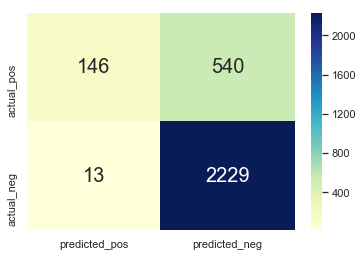

In [71]:
cm = confusion_matrix(Y_test, y_pred_tv)
sns.heatmap(cm, xticklabels=['predicted_pos', 'predicted_neg'], yticklabels=['actual_pos', 'actual_neg'], annot=True, fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
true_neg, false_pos = cm[0]
false_neg, true_pos = cm[1]
accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
precision = round((true_pos) / (true_pos + false_pos),3)
recall = round((true_pos) / (true_pos + false_neg),3)
f1 = round(2 * (precision * recall) / (precision + recall),3)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F1 Score: {}'.format(f1))